In [ ]:
# COLAB_NORM = True

# if COLAB_NORM:
#     from google.colab import drive
#     drive.mount('/content/drive')

In [33]:
!pip install lxml
!pip install koreanize_matplotlib
!pip install opencv-python

In [34]:
# 가끔 아래의 에러가 발생할 경우 다음 코드를 실행한다.
# 로케일 에러
# NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
import lxml
import os
import glob

from lxml import etree

In [36]:
import matplotlib.patches as patches
import cv2
import torch

In [4]:
bucket_name = 'sesac-highway-15'
mount_path='/home/jupyter/test'

In [25]:
# 폴더를 생성하는 함수
# os.makedirs(mount_path, exist_ok=True)

In [20]:
# !gcsfuse --implicit-dirs {bucket_name} {mount_path}

{"time":"22/11/2023 03:58:29.383019","severity":"INFO","msg":"Start gcsfuse/1.2.0 (Go version go1.21.0) for app \"\" using mount point: /home/jupyter/test\n"}


## unzip

In [15]:
basePath = mount_path

In [32]:
mount_path

'/home/jupyter/test'

In [41]:
# dataPath='/home/jupyter/test/highway'
# #os.makedirs(os.path.join(dataPath), exist_ok=True)

In [39]:
!pwd

/home/jupyter


In [40]:
%cd {mount_path}

/home/jupyter/test


In [46]:
# zipfilePath = os.path.join(mount_path,'my_highway.zip')
# zf = zipfile.ZipFile(zipfilePath)   
# zf.infolist()

In [5]:
destPath = '/home/jupyter/data/'
os.makedirs(destPath, exist_ok=True)

In [50]:
!cp /home/jupyter/test/my_highway.zip ~/

^C


In [52]:
%%time
import zipfile
import multiprocessing
import concurrent.futures

def unzip(files):
    with lock:
        zf.extract(files, path=destPath)

zipfilePath = os.path.join(mount_path,'my_highway.zip')
print(zipfilePath)
destPath = destPath

zf = zipfile.ZipFile(zipfilePath)    
m = multiprocessing.Manager()
lock = m.Lock()
ZipInfo=[]
with concurrent.futures.ProcessPoolExecutor(max_workers=10) as executor:
    # zf.infolist()는 압축파일 안에 있는 파일들의 목록
    executor.map(unzip, zf.infolist())

/home/jupyter/test/my_highway.zip
CPU times: user 18.1 s, sys: 4.4 s, total: 22.5 s
Wall time: 8min 25s


In [ ]:
# 한글깨짐 현상 -> mv 처리

In [59]:
!pwd

/home/jupyter


In [64]:
os.makedirs('dataset/highway/train/images', exist_ok=True)

In [65]:
os.makedirs('dataset/highway/train/labels', exist_ok=True)

In [66]:
os.makedirs('dataset/highway/validation/images', exist_ok=True)

In [67]:
os.makedirs('dataset/highway/validation/labels', exist_ok=True)

In [68]:
!mv data/bbox_highway/train/image_╝÷╡╡▒╟┐╡╡┐╝▒/* dataset/highway/train/images

In [69]:
!mv data/bbox_highway/train/label_╝÷╡╡▒╟┐╡╡┐╝▒/* dataset/highway/train/labels

In [70]:
!mv data/bbox_highway/validation/image_╝÷╡╡▒╟┐╡╡┐╝▒/* dataset/highway/validation/images

In [71]:
!mv data/bbox_highway/validation/label_╝÷╡╡▒╟┐╡╡┐╝▒/* dataset/highway/validation/labels

In [ ]:
# train data의 label xml --> txt 처리

In [124]:
!pwd

/home/jupyter/dataset/highway


## xml to txt

In [5]:
import glob
from lxml import etree

In [6]:
CLASSES = ["car", "bus", "truck"]

def to_yolov8(y):
  """
  # change to yolo v8 format
  # [x_top_left, y_top_left, x_bottom_right, y_bottom_right] to
  # [x_center, y_center, width, height]
  """
  width = y[2] - y[0]
  height = y[3] - y[1]

  if width < 0 or height < 0:
      print("ERROR: negative width or height ", width, height, y)
      raise AssertionError("Negative width or height")
  return (y[0] + (width/2)), (y[1] + (height/2)), width, height

def load_xml_annotations(f):
  tree = etree.parse(f)
  anns = []
  for dim in tree.xpath("image"):
    image_filename = dim.attrib["name"]
    width = int(dim.attrib["width"])
    height = int(dim.attrib["height"])
    # print(image_filename)
    # print(len(dim.xpath("box")))
    boxes = []
    for box in dim.xpath("box"):
      label = CLASSES.index(box.attrib["label"])
      xtl, ytl = box.attrib["xtl"], box.attrib["ytl"]
      xbr, ybr = box.attrib["xbr"], box.attrib["ybr"]

      xc, yc, w, h = to_yolov8([float(xtl), float(ytl), float(xbr), float(ybr)])
      boxes.append([label, round(xc/width, 5), round(yc/height, 5), round(w/width, 5), round(h/height, 5)])

    anns.append([image_filename, width, height, boxes])

  return np.array(anns, dtype='object')

def write_yolov8_txt(folder, annotation):
  out_filename1 = str(folder + annotation[0][:-3])
  out_filename = os.path.splitext(out_filename1)[0]
  out_filename = out_filename+'.txt'

  f = open(out_filename,"w+")
  for box in annotation[3]:
    f.write("{} {} {} {} {}\n".format(box[0], box[1], box[2], box[3], box[4]))


In [7]:
!pwd

/home/jupyter


In [8]:
t_dataPath = '/home/jupyter/dataset/highway/train/labels'
t_dataPath

'/home/jupyter/dataset/highway/train/labels'

In [9]:
# xml 폴더 리스트
t_xml_list = glob.glob(t_dataPath+'/*.xml', recursive=True)
t_xml_list

['/home/jupyter/dataset/highway/train/labels/Suwon_CH03_20200722_1500_WED_9m_NH_highway_OW5_rainy_FHD.xml',
 '/home/jupyter/dataset/highway/train/labels/Suwon_CH03_20200721_1700_TUE_9m_RH_highway_OW5_sunny_FHD.xml',
 '/home/jupyter/dataset/highway/train/labels/Suwon_CH02_20200721_1830_TUE_9m_RH_highway_TW5_sunny_FHD.xml',
 '/home/jupyter/dataset/highway/train/labels/Suwon_CH03_20200722_1800_WED_9m_NH_highway_OW5_sunny_FHD.xml',
 '/home/jupyter/dataset/highway/train/labels/Suwon_CH03_20200722_1400_WED_9m_NH_highway_OW5_rainy_FHD.xml',
 '/home/jupyter/dataset/highway/train/labels/Suwon_CH01_20200721_1530_TUE_9m_NH_highway_TW5_sunny_FHD.xml',
 '/home/jupyter/dataset/highway/train/labels/Suwon_CH03_20200722_1630_WED_9m_NH_highway_OW5_sunny_FHD.xml',
 '/home/jupyter/dataset/highway/train/labels/Suwon_CH03_20201010_1812_SAT_9m_RH_highway_OW5_sunny_FHD.xml',
 '/home/jupyter/dataset/highway/train/labels/Suwon_CH03_20201012_1903_MON_9m_RH_highway_OW5_sunny_FHD.xml',
 '/home/jupyter/dataset/high

In [10]:
!pwd

/home/jupyter


In [11]:
# pwd 하위에 train_label_per_image 폴더 만듦
os.makedirs("/home/jupyter/dataset/highway/train/train_label_per_image",exist_ok=True)

### xml to txt 핵심코드

In [12]:
# for xml in t_xml_list:
#     # name_splited = xml.split('\\')
#     # file_name = name_splited[-1]
#     # file_name_splited = file_name.split("_")
#     # if int(file_name_splited[1][-2:]) <= 4: #ch의 뒷자리가 4 이하
#         #print(xml)
#         anns = load_xml_annotations(xml)
#         #print(anns)
#         dir_name = xml.split('/')[-1][:-4] # 마지막 폴더명에서 .xml 뗀 거
#         #print(dir_name)
#         # # 1. labels 하위에 txt파일 전부 넣고 싶은 경우
#         # # full_dir_name = HOME+"\\train\\labels"

#         # 2. 하위 폴더마다 txt파일 넣고 싶은 경우
#         full_dir_name = '/home/jupyter/dataset/highway/train/train_label_per_image/' + dir_name

#         os.makedirs(full_dir_name, exist_ok=True)
#         for ann in anns:
#            write_yolov8_txt(full_dir_name+"/", ann)

In [ ]:
# val data의 xml --> txt 처리

In [13]:
v_dataPath = '/home/jupyter/dataset/highway/validation/labels'
v_dataPath

'/home/jupyter/dataset/highway/validation/labels'

In [173]:
# xml 폴더 리스트
v_xml_list = glob.glob(v_dataPath+'/*.xml', recursive=True)
v_xml_list

['/home/jupyter/dataset/highway/validation/labels/Suwon_CH02_20200720_2130_MON_9m_NH_highway_TW5_sunny_FHD.xml',
 '/home/jupyter/dataset/highway/validation/labels/Suwon_CH09_20200720_1900_MON_9m_NH_highway_OW5_sunny_FHD.xml',
 '/home/jupyter/dataset/highway/validation/labels/Suwon_CH09_20200721_1730_TUE_9m_NH_highway_OW5_sunny_FHD.xml',
 '/home/jupyter/dataset/highway/validation/labels/Suwon_CH09_20201012_1903_MON_9m_RH_highway_OW5_sunny_FHD.xml',
 '/home/jupyter/dataset/highway/validation/labels/Suwon_CH01_20201213_1200_SUN_9m_NH_highway_TW5_snow_FHD.xml',
 '/home/jupyter/dataset/highway/validation/labels/Suwon_CH08_20200720_1830_MON_9m_NH_highway_OW5_sunny_FHD.xml',
 '/home/jupyter/dataset/highway/validation/labels/Suwon_CH10_20200721_1700_TUE_9m_NH_highway_TW5_sunny_FHD.xml',
 '/home/jupyter/dataset/highway/validation/labels/Suwon_CH07_20201010_1805_SAT_9m_RH_highway_OW5_sunny_FHD.xml',
 '/home/jupyter/dataset/highway/validation/labels/Suwon_CH04_20201010_1818_SAT_9m_RH_highway_OW5_

In [174]:
!pwd

/home/jupyter/dataset/highway


In [175]:
# pwd 하위에 valid_label_per_image 폴더 만듦
os.makedirs("/home/jupyter/dataset/highway/validation/valid_label_per_image",exist_ok=True)

In [176]:
for xml in v_xml_list:
    # name_splited = xml.split('\\')
    # file_name = name_splited[-1]
    # file_name_splited = file_name.split("_")
    # if int(file_name_splited[1][-2:]) <= 4: #ch의 뒷자리가 4 이하
        #print(xml)
        anns = load_xml_annotations(xml)
        # print(anns)
        dir_name = xml.split('/')[-1][:-4] # 마지막 폴더명에서 .xml 뗀 거

        # # 1. labels 하위에 txt파일 전부 넣고 싶은 경우
        # # full_dir_name = HOME+"\\valid\\labels"

        # 2. 하위 폴더마다 txt파일 넣고 싶은 경우
        full_dir_name = '/home/jupyter/dataset/highway/validation/valid_label_per_image/' + dir_name

        os.makedirs(full_dir_name, exist_ok=True)
        for ann in anns:
           write_yolov8_txt(full_dir_name+"/", ann)

## 레이블 시각화 하기

In [ ]:
# 레이블 시각화 하기

In [7]:
dataPath = '/home/jupyter/dataset/highway'

In [8]:
dataPath

'/home/jupyter/dataset/highway'

In [9]:
import glob
import os

def glob_files(path, file_type="*"):
    search_string = os.path.join(path, file_type)
    #print(search_string)
    files = glob.glob(search_string)

    #print('searching ', path)
    paths = []
    for f in files:
        if os.path.isdir(f):
            sub_paths = glob_files(f + '/')
            paths += sub_paths
        else:
            paths.append(f)

    # We sort the images in alphabetical order to match them
    #  to the annotation files
    paths.sort()

    return paths

In [10]:
glob_files(dataPath+"/train/images/Suwon_CH01_20200720_1700_MON_9m_NH_highway_TW5_sunny_FHD", file_type="*")

['/home/jupyter/dataset/highway/train/images/Suwon_CH01_20200720_1700_MON_9m_NH_highway_TW5_sunny_FHD/Suwon_CH01_20200720_1700_MON_9m_NH_highway_TW5_sunny_FHD_001.png',
 '/home/jupyter/dataset/highway/train/images/Suwon_CH01_20200720_1700_MON_9m_NH_highway_TW5_sunny_FHD/Suwon_CH01_20200720_1700_MON_9m_NH_highway_TW5_sunny_FHD_002.png',
 '/home/jupyter/dataset/highway/train/images/Suwon_CH01_20200720_1700_MON_9m_NH_highway_TW5_sunny_FHD/Suwon_CH01_20200720_1700_MON_9m_NH_highway_TW5_sunny_FHD_003.png',
 '/home/jupyter/dataset/highway/train/images/Suwon_CH01_20200720_1700_MON_9m_NH_highway_TW5_sunny_FHD/Suwon_CH01_20200720_1700_MON_9m_NH_highway_TW5_sunny_FHD_004.png',
 '/home/jupyter/dataset/highway/train/images/Suwon_CH01_20200720_1700_MON_9m_NH_highway_TW5_sunny_FHD/Suwon_CH01_20200720_1700_MON_9m_NH_highway_TW5_sunny_FHD_005.png',
 '/home/jupyter/dataset/highway/train/images/Suwon_CH01_20200720_1700_MON_9m_NH_highway_TW5_sunny_FHD/Suwon_CH01_20200720_1700_MON_9m_NH_highway_TW5_sunny_

In [11]:
dataPath+"/train/images/"


'/home/jupyter/dataset/highway/train/images/'

In [14]:
import cv2
import numpy as np

IMAGE_SIZE = 600

def load_images(path):
    files = glob_files(path, "*.png")

    # print(files)
    X_data = []
    for file in files:
        image = cv2.imread(file)
    # print(image.shape)
    # x = cv2.resize(image, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)

        X_data.append(image)
    return np.array(X_data)

X_test = load_images(dataPath+"/train/images/Suwon_CH01_20200720_1700_MON_9m_NH_highway_TW5_sunny_FHD")

In [15]:
X_test

array([[[[155, 146, 136],
         [155, 146, 136],
         [155, 146, 136],
         ...,
         [ 79,  70,  60],
         [ 81,  72,  62],
         [ 78,  69,  59]],

        [[155, 146, 136],
         [155, 146, 136],
         [155, 146, 136],
         ...,
         [ 78,  69,  59],
         [ 80,  71,  61],
         [ 78,  69,  59]],

        [[156, 147, 137],
         [156, 147, 137],
         [156, 147, 137],
         ...,
         [ 78,  69,  59],
         [ 79,  70,  60],
         [ 78,  69,  59]],

        ...,

        [[114, 117, 115],
         [114, 117, 115],
         [114, 117, 115],
         ...,
         [ 75,  75,  75],
         [ 75,  75,  75],
         [ 76,  76,  76]],

        [[112, 115, 113],
         [112, 115, 113],
         [112, 115, 113],
         ...,
         [ 74,  74,  74],
         [ 74,  74,  74],
         [ 75,  75,  75]],

        [[110, 113, 111],
         [110, 113, 111],
         [110, 113, 111],
         ...,
         [ 73,  73,  73],
        

In [26]:
# folder_trainImage_list = glob.glob('/home/jupyter/dataset/highway/train/images/*', recursive=True)
# folder_trainImage_list

In [27]:
# folder_trainlabel_list = glob.glob('/home/jupyter/dataset/highway/train/train_label_per_image/*/*', recursive=True)
# folder_trainlabel_list

In [22]:
WIDTH = 1080
HEIGHT = 1920

def load_labels(path):
    files = glob_files(path, "*.txt")

    Y_data = []
    for file in files:
        with open(file) as f:
            lines = f.readlines()

    boxes = []
    for line in lines:
        tokens = line.split()

        class_id = int(tokens[0])
        xc = float(tokens[1]) * WIDTH
        yc = float(tokens[2]) * HEIGHT
        width = float(tokens[3]) * WIDTH
        height = float(tokens[4]) * HEIGHT

        boxes.append(np.array([class_id, xc, yc, width, height]))
        # print(class_id, xc, yc, width, height)

    Y_data.append(np.array(boxes))
    # print(lines)
    return np.array(Y_data)

Y_test = load_labels(dataPath+"/train/labels/train_label_per_image/Suwon_CH01_20200720_1700_MON_9m_NH_highway_TW5_sunny_FHD")

In [23]:
print(Y_test)

[[[0.000000e+00 1.172448e+02 7.220160e+02 6.950880e+01 4.222080e+01]
  [1.000000e+00 1.553580e+02 6.432000e+02 7.847280e+01 7.920000e+01]
  [2.000000e+00 6.536592e+02 4.841472e+02 5.017680e+01 4.391040e+01]
  [0.000000e+00 3.211596e+02 5.885760e+02 3.842640e+01 3.148800e+01]
  [1.000000e+00 9.544500e+02 4.297536e+02 4.217400e+01 3.421440e+01]
  [2.000000e+00 7.049052e+02 4.799424e+02 5.017680e+01 5.452800e+01]
  [2.000000e+00 5.412960e+02 5.509248e+02 5.285520e+01 6.410880e+01]
  [2.000000e+00 4.361256e+02 5.989632e+02 6.566400e+01 7.691520e+01]
  [2.000000e+00 3.774168e+02 5.925504e+02 6.351480e+01 7.689600e+01]
  [0.000000e+00 2.479680e+02 6.376704e+02 4.590000e+01 3.048960e+01]
  [0.000000e+00 1.348056e+02 7.396224e+02 7.152840e+01 5.289600e+01]
  [0.000000e+00 2.363040e+01 6.939840e+02 4.726080e+01 4.809600e+01]
  [2.000000e+00 9.655524e+02 4.932864e+02 4.407480e+01 5.312640e+01]
  [0.000000e+00 4.994460e+02 8.951808e+02 1.075896e+02 9.068160e+01]
  [0.000000e+00 7.739280e+01 1.307

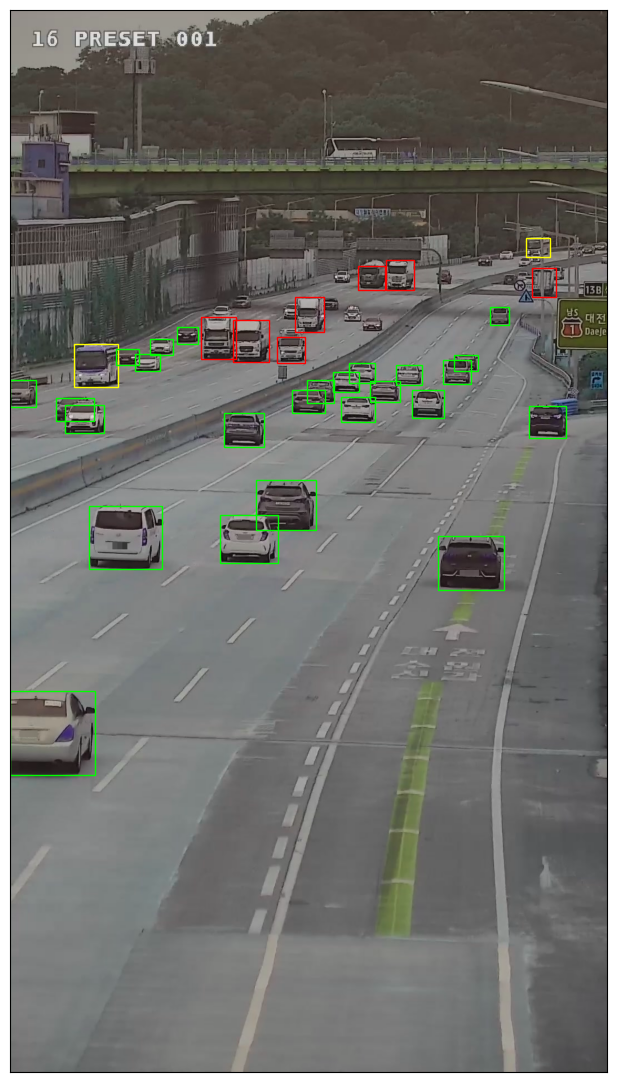

In [24]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def create_patch_rectangle(y, color):
  # # in yolov5
  width = int(y[2])
  height = int(y[3])
  return patches.Rectangle((int(y[0] - width/2), int(y[1] - height/2)),
                           width, height,
                           edgecolor=color, fill=False)

COLORS = [(0, 255/255, 0), (255/255, 255/255, 0), (255/255, 0, 0)]

def plot_image(image, boxes, axis):
  # # print(boxes.shape)
  for box in boxes:
    # print(box)
    class_id = int(box[0])
    # print(type(class_id), class_id)
    rect = create_patch_rectangle(box[1:], COLORS[class_id])
    axis.add_patch(rect)

  plt.imshow(image)

def plot_images(X, Y, limit=10):
  fig = plt.figure(figsize=(100, 80))

  last_id = min(limit, X.shape[0])
  for id in range(last_id):
    axis = fig.add_subplot(5, 3, id + 1)
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)
    plot_image(X[id], Y[id], axis)

plot_images(np.array([X_test[-1]]), np.array([Y_test[-1]]))

In [ ]:
# train --> train/val로 분할 후 dataset 집어넣기

In [ ]:
# bucket_name = 'sessac-project-13-bucket'
# mount_path = '/home/jupyter/dataset'
# !gcsfuse --implicit-dirs {bucket_name} {mount_path}

In [ ]:
# HOME = os.getcwd()
# HOME

In [26]:
# dataPath

'/home/jupyter/dataset/highway'

In [27]:
# from glob import glob
# import os

# #HOME = os.getcwd()
# # frombasePath = '{}/dataset/highway_total/train/label'.format(HOME)
# # tobasePath = '{}/highway/bbox_highway/train/labels'.format(HOME)

# frombasePath = dataPath+'/train/labels'

# train_filename = []
# for filepath in glob(os.path.join(frombasePath, '*.xml')):
#     filename = os.path.basename(filepath)
#     filename = filename[:-4]
#     train_filename.append(filename)

# len(train_filename)

168

In [28]:
# train_filename[167]

'Suwon_CH01_20200721_2100_TUE_9m_NH_highway_TW5_sunny_FHD'

In [ ]:
# train_filename[168]

In [ ]:
### python module 시도(성공) : valid

In [ ]:
# len(list(range(0, 168, 5)))

In [ ]:
# for i in range(0, 168, 5):
#     print(train_filename[i])

In [ ]:
# from distutils.dir_util import copy_tree

# # frombasePath_valid = '{}/dataset/highway_total/train/label'.format(HOME)
# tobasePath_val = '{}/highway/bbox_highway/val/labels'.format(HOME)

# for i in range(0, 168, 5):
#     testfolderPath = os.path.join(frombasePath, train_filename[i])
#     copy_tree(testfolderPath, tobasePath_val)

In [ ]:
# frombasePath_trainImg = '{}/dataset/highway_total/train'.format(HOME)
# tobasePath_valImg = '{}/highway/bbox_highway/val/images'.format(HOME)

# for i in range(0, 168, 5):
#     testfolderPath = os.path.join(frombasePath_trainImg, train_filename[i])
#     copy_tree(testfolderPath, tobasePath_valImg)

In [ ]:
### python module 시도(성공) : train

In [ ]:
# len(list(set(range(0, 168)) - set(range(0, 168, 5))))

In [ ]:
# tobasePath = '{}/highway/bbox_highway/train/labels'.format(HOME)

# for i in list(set(range(0, 168)) - set(range(0, 168, 5))):
#     testfolderPath = os.path.join(frombasePath, train_filename[i])
#     copy_tree(testfolderPath, tobasePath)

In [ ]:
# # frombasePath_trainImg = '{}/dataset/highway_total/valid/image/BB_01수도권영동선_Validation_image'.format(HOME)
# tobasePath_trainImg = '{}/highway/bbox_highway/train/images'.format(HOME)

# for i in list(set(range(0, 168)) - set(range(0, 168, 5))):
#     testfolderPath = os.path.join(frombasePath_trainImg, train_filename[i])
#     copy_tree(testfolderPath, tobasePath_trainImg)

In [ ]:
# import distutils

# distutils.__version__

In [ ]:
# import numpy

# numpy.__version__

In [ ]:
# import lxml

# lxml.__version__

In [ ]:
# val --> test로 dataset 집어넣기

In [ ]:
# from glob import glob
# import os

# HOME = os.getcwd()
# frombasePath = '{}/dataset/highway_total/valid/label'.format(HOME)
# tobasePath = '{}/highway/bbox_highway/test/labels'.format(HOME)

# valid_filename = []
# for filepath in glob(os.path.join(frombasePath, '*.xml')):
#     filename = os.path.basename(filepath)
#     filename = filename[:-4]
#     valid_filename.append(filename)

# len(valid_filename)

In [ ]:
# valid_filename[:21]

In [ ]:
# from distutils.dir_util import copy_tree

# copy_tree(testfolderPath, tobasePath)

In [ ]:
# # from distutils.dir_util import copy_tree

# for folder in valid_filename[:21]:
#     testfolderPath = os.path.join(frombasePath, folder)
#     copy_tree(testfolderPath, tobasePath)

In [ ]:
# frombasePath_validImg = '{}/dataset/highway_total/valid/image/BB_01수도권영동선_Validation_image'.format(HOME)
# tobasePath_validImg = '{}/highway/bbox_highway/test/images'.format(HOME)

# for folder in valid_filename[:21]:
#     testfolderPath = os.path.join(frombasePath_validImg, folder)
#     copy_tree(testfolderPath, tobasePath_validImg)

In [ ]:
# 데이터셋 경로 설정하기

In [32]:
!pwd

/home/jupyter


In [34]:
dataPath

'/home/jupyter/dataset/highway'

In [51]:
import os
from glob import glob

trainPath = os.path.join(dataPath,'train')
validPath = os.path.join(dataPath,'valid')
testPath  = os.path.join(dataPath,'test')

trainImagesPath = os.path.join(trainPath, 'images')
validImagesPath = os.path.join(validPath, 'images')
testImagesPath  = os.path.join(testPath,  'images')

trainLabelsPath = os.path.join(trainPath, 'labels')
validLabelsPath = os.path.join(validPath, 'labels')
testLabelsPath  = os.path.join(testPath,  'labels')

In [52]:
# train/images
os.makedirs(trainImagesPath, exist_ok=True)
os.makedirs(validImagesPath, exist_ok=True)
os.makedirs(testImagesPath, exist_ok=True)

os.makedirs(trainLabelsPath, exist_ok=True)
os.makedirs(validLabelsPath, exist_ok=True)
os.makedirs(testLabelsPath, exist_ok=True)

In [37]:
trainImagesPath, trainLabelsPath

('/home/jupyter/dataset/highway/train/images',
 '/home/jupyter/dataset/highway/train/labels')

In [38]:
testImagesPath, testLabelsPath

('/home/jupyter/dataset/highway/test/images',
 '/home/jupyter/dataset/highway/test/labels')

In [39]:
validImagesPath, validLabelsPath

('/home/jupyter/dataset/highway/valid/images',
 '/home/jupyter/dataset/highway/valid/labels')

In [ ]:
# for filename in glob(os.path.join(trainPath,'*.png')):
#     basename = os.path.basename(filename)
#     os.rename(filename, os.path.join(trainImagesPath,basename))

# for filename in glob(os.path.join(validPath,'*.png')):
#     basename = os.path.basename(filename)
#     os.rename(filename, os.path.join(validImagesPath,basename))

# for filename in glob(os.path.join(testPath,'*.png')):
#     basename = os.path.basename(filename)
#     os.rename(filename, os.path.join(testImagesPath,basename))


# for filename in glob(os.path.join(trainPath,'*.txt')):
#     basename = os.path.basename(filename)
#     os.rename(filename, os.path.join(trainLabelsPath,basename))

# for filename in glob(os.path.join(validPath,'*.txt')):
#     basename = os.path.basename(filename)
#     os.rename(filename, os.path.join(validLabelsPath,basename))

# for filename in glob(os.path.join(testPath,'*.txt')):
#     basename = os.path.basename(filename)
#     os.rename(filename, os.path.join(testLabelsPath,basename))

In [37]:
import torch

In [38]:
HOME='home/jupyter'

In [39]:
!pwd

/home/jupyter/ultralytics/ultralytics


In [21]:
%cd '/home/jupyter'

/home/jupyter


In [22]:
# !pip uninstall -y ultralytics
!pip install ultralytics

  Using cached ultralytics-8.0.216-py3-none-any.whl.metadata (31 kB)
Using cached ultralytics-8.0.216-py3-none-any.whl (645 kB)


In [25]:
%cd {HOME}
!git clone https://github.com/ultralytics/ultralytics
%cd ultralytics

[Errno 2] No such file or directory: 'home/jupyter'
/home/jupyter
Cloning into 'ultralytics'...
remote: Enumerating objects: 19401, done.
remote: Counting objects: 100% (585/585), done.
remote: Compressing objects: 100% (338/338), done.
remote: Total 19401 (delta 296), reused 450 (delta 246), pack-reused 18816
Receiving objects: 100% (19401/19401), 10.84 MiB | 14.59 MiB/s, done.
Resolving deltas: 100% (13462/13462), done.
/home/jupyter/ultralytics


In [40]:
%cd ultralytics

[Errno 2] No such file or directory: 'ultralytics'
/home/jupyter/ultralytics/ultralytics


In [41]:
from IPython.display import Image, clear_output  # to display images

clear_output()
print(f"Setup complete. Using torch {torch.__version__} \
    ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.13.1+cu117     (NVIDIA A100-SXM4-40GB)


In [ ]:
# HOME

In [ ]:
# Train Vehicle Detection Model

In [44]:
%cd ultralytics
!ls -al

[Errno 2] No such file or directory: 'ultralytics'
/home/jupyter/ultralytics/ultralytics
total 48
drwxr-xr-x 11 jupyter jupyter 4096 Nov 24 05:08 .
drwxr-xr-x  9 jupyter jupyter 4096 Nov 24 05:08 ..
-rw-r--r--  1 jupyter jupyter  463 Nov 24 05:08 __init__.py
drwxr-xr-x  2 jupyter jupyter 4096 Nov 24 05:08 assets
drwxr-xr-x  5 jupyter jupyter 4096 Nov 24 05:08 cfg
drwxr-xr-x  3 jupyter jupyter 4096 Nov 24 05:08 data
drwxr-xr-x  2 jupyter jupyter 4096 Nov 24 05:08 engine
drwxr-xr-x  2 jupyter jupyter 4096 Nov 24 05:08 hub
drwxr-xr-x  8 jupyter jupyter 4096 Nov 24 05:08 models
drwxr-xr-x  3 jupyter jupyter 4096 Nov 24 05:08 nn
drwxr-xr-x  3 jupyter jupyter 4096 Nov 24 05:08 trackers
drwxr-xr-x  3 jupyter jupyter 4096 Nov 24 05:08 utils


In [45]:
from IPython.core.magic import register_line_cell_magic

# yaml에 직접 쓰기를 실행하는 함수
@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [48]:
dataPath='/home/jupyter/dataset/highway'

In [49]:
dataYaml = os.path.join(dataPath,'data.yaml')
dataYaml

'/home/jupyter/dataset/highway/data.yaml'

In [53]:
print(trainImagesPath)
print(validImagesPath)
print(testImagesPath)

/home/jupyter/dataset/highway/train/images
/home/jupyter/dataset/highway/valid/images
/home/jupyter/dataset/highway/test/images


In [54]:
%%writetemplate {dataYaml}
train: /home/jupyter/dataset/highway/train/images
val: /home/jupyter/dataset/highway/valid/images
test: /home/jupyter/dataset/highway/test/images

nc: 3
names: ['car', 'bus', 'truck']

In [ ]:
# 학습과정

In [50]:
# %cd {HOME}
# %cd ultralytics

/home/jupyter
/home/jupyter/ultralytics


In [ ]:
#!pip install ultralytics==8.0.20

In [52]:
import os
os.chdir('/home/jupyter/ultralytics')

In [54]:
# from ultralytics import YOLO

# # Load a model
# # model = YOLO('yolov8n.yaml')  # build a new model from YAML
# # model = YOLO('yolov8n.pt')  # load a pretrained model (recommended for training)
# model = YOLO('yolov8n.yaml').load('yolov8n.pt')  # build from YAML and transfer weights

# # Train the model
# results = model.train(data=dataYaml, epochs=100, imgsz=640)

ImportError: cannot import name 'YOLO' from 'ultralytics' (unknown location)

In [56]:
!pip install pillow==9.5.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 31.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pillow
    Found existing installation: Pillow 10.0.1
    Uninstalling Pillow-10.0.1:
      Successfully uninstalled Pillow-10.0.1


In [58]:
# epochs를 100 혹은 150으로 증가하여 재학습필요
%cd {HOME}

!yolo task=detect mode=train model=yolov8n.pt data=/home/jupyter/dataset/highway/data.yaml epochs=75 imgsz=640 plots=True batch=16 workers=10 cache=True

/home/jupyter
Ultralytics YOLOv8.0.20 🚀 Python-3.10.13 torch-1.13.1+cu117 CUDA:0 (NVIDIA A100-SXM4-40GB, 40354MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/home/jupyter/dataset/highway/data.yaml, epochs=75, patience=50, batch=16, imgsz=640, save=True, cache=True, device=, workers=10, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8

In [ ]:
%cd {HOME}

!yolo task=detect mode=train model=yolov8s.pt data=/home/jupyter/dataset/highway/data.yaml epochs=100 imgsz=640 plots=True batch=32 workers=10 cache=True

[Errno 2] No such file or directory: 'home/jupyter'
/home/jupyter/ultralytics/ultralytics
100%|███████████████████████████████████████| 21.5M/21.5M [00:00<00:00, 339MB/s]
Ultralytics YOLOv8.0.216 🚀 Python-3.10.13 torch-1.13.1+cu117 CUDA:0 (NVIDIA A100-SXM4-40GB, 40354MiB)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/home/jupyter/dataset/highway/data.yaml, epochs=100, patience=50, batch=32, imgsz=640, save=True, save_period=-1, cache=True, device=None, workers=10, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=

In [4]:
!pwd

/home/jupyter


In [ ]:
%cd {HOME}

!yolo task=detect mode=train model=yolov8m.pt data=/home/jupyter/dataset/highway/data.yaml epochs=100 imgsz=640 plots=True batch=32 workers=10 cache=True

[Errno 2] No such file or directory: '{HOME}'
/home/jupyter
Ultralytics YOLOv8.0.216 🚀 Python-3.10.13 torch-1.13.1+cu117 CUDA:0 (NVIDIA A100-SXM4-40GB, 40354MiB)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/home/jupyter/dataset/highway/data.yaml, epochs=150, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=True, device=None, workers=10, project=None, name=train10, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False,

In [ ]:
# from ultralytics import YOLO

# # Load a model
# # model = YOLO('yolov8s.yaml')  # build a new model from YAML
# # model = YOLO('yolov8s.pt')  # load a pretrained model (recommended for training)
# model = YOLO('yolov8s.yaml').load('yolov8s.pt')  # build from YAML and transfer weights

# # Train the model
# results = model.train(data=dataYaml, epochs=400, imgsz=640, batch=10)

In [ ]:
# from ultralytics import YOLO

# # Load a model
# # model = YOLO('yolov8s.yaml')  # build a new model from YAML
# # model = YOLO('yolov8s.pt')  # load a pretrained model (recommended for training)
# model = YOLO('yolov8m.yaml').load('yolov8m.pt')  # build from YAML and transfer weights

# # Train the model
# results = model.train(data=dataYaml, epochs=400, imgsz=640, batch=10)

In [ ]:
# import os
# os.getcwd()

In [ ]:
# testImages = 'dataset/highway/test/images'
# from glob import glob

# testList =[]
# for filename in glob(os.path.join(testImages, '*.png')):
#     testList.append(filename)

In [ ]:
# testList

In [ ]:
# from ultralytics import YOLO

# resultList =[]

# # Load a pretrained YOLOv8n model
# model = YOLO('home/jupyter/runs/detect/train3/weights/best.pt')

# # Run inference on images
# results = model(testList)

# # View results
# for result in results:
#     resultList.append(result.cpu().numpy().boxes.cls)  # print the Boxes object containing the detection bounding boxes

In [ ]:
# import pandas as pd
# sum = [0, 0, 0]

# for result in resultList:
#     for i in range(len(sum)):
#         sum[i] += result.tolist().count(i)
# print(sum)

# print("전체 {}장의 이미지에서 승용차 {}대, 버스 {}대, 트럭 {}대를 발견하였습니다.".format(len(resultList), sum[0], sum[1], sum[2]))

In [ ]:
# Dongwon_nim code

In [2]:
### 학습된 모델을 테스트 하는 방법
### 1. ultralytics버전을 확인 하세요.
### 새로운 버전이 나왔습니다.ㅜㅜ 

#!pip list | grep ultra
#ultralytics                              8.0.216

### 2. 기존 ultralytics버전을 삭제하고 신규 버전으로 확인 하세요.

# !pip uninstall -y ultralytics
# !pip install ultralytics

### 3. 학습된 모델을 선택하고, 테스트할 부분을 넣으면 됩니다.
### 아래의 내용은 동영상으로 테스트 하였습니다.

model = '/home/jupyter/runs/detect/train8/weights/best.pt'
source = '/home/jupyter/dataset/highway/test/images/Suwon_CH04_20200722_1700_WED_9m_NH_highway_OW5_sunny_FHD/Suwon_CH04_20200722_1700_WED_9m_NH_highway_OW5_sunny_FHD_001.png'

### 4. CLI로 테스트 하세요. Python 버전은 안됩니다!

!yolo task=detect mode=predict show=True model={model} source={source} imgsz=640 save=True name='highway_test'

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()

Ultralytics YOLOv8.0.216 🚀 Python-3.10.13 torch-1.13.1+cu117 CUDA:0 (NVIDIA A100-SXM4-40GB, 40354MiB)
Model summary (fused): 218 layers, 25841497 parameters, 0 gradients, 78.7 GFLOPs

image 1/2706 /home/jupyter/dataset/highway/test/images/Suwon_CH04_20200722_1700_WED_9m_NH_highway_OW5_sunny_FHD/Suwon_CH04_20200722_1700_WED_9m_NH_highway_OW5_sunny_FHD_001.png: 640x384 6 cars, 1 bus, 3 trucks, 23.2ms
image 2/2706 /home/jupyter/dataset/highway/test/images/Suwon_CH04_20200722_1700_WED_9m_NH_highway_OW5_sunny_FHD/Suwon_CH04_20200722_1700_WED_9m_NH_highway_OW5_sunny_FHD_002.png: 640x384 5 cars, 1 bus, 1 truck, 15.7ms
image 3/2706 /home/jupyter/dataset/highway/test/images/Suwon_CH04_20200722_1700_WED_9m_NH_highway_OW5_sunny_FHD/Suwon_CH04_20200722_1700_WED_9m_NH_highway_OW5_sunny_FHD_003.png: 640x384 8 cars, 1 bus, 1 truck, 15.4ms
image 4/2706 /home/jupyter/dataset/highway/test/images/Suwon_CH04_20200722_1700_WED_9m_NH_